### [The spelled-out intro to neural networks and backpropagation: building micrograd](https://www.youtube.com/watch?v=VMj-3S1tku0&t=3356s)

### [chatGPT-4, released on 2023-03-14, has 1 trillion paramaters and cost $100 million to train](https://en.wikipedia.org/wiki/GPT-4)

In [1]:
import math, random, torch
import numpy as np
# import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def plot_losses(losses):
  # import matplotlib.pyplot as plt
  
  # Create a list of iterations
  iterations = range(len(losses))

  # Plot the loss as a function of iteration
  plt.plot(iterations, losses)

  # Add a title to the plot
  plt.title('Loss vs. Iteration')

  # Add labels to the x-axis and y-axis
  plt.xlabel('Iteration')
  plt.ylabel('Loss')

### Micrograd Classes and Functions<br>* limited to neural network with one output, e.g. MLP(2, [3, 1])<br>* neural network with multiple outputs, e.g.  MLP(2, [3, 3]), will produce errors in backward pass 

In [3]:
from graphviz import Digraph

def trace(root):
  """Builds a set of all nodes and edges in a graph."""
  nodes, edges = set(), set()

  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)

  build(root)
  return nodes, edges

def draw_dot(root):
  """Creates a Digraph representation of the graph."""
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # For any value in the graph, create a rectangular ('record') node for it.
    dot.node(name=uid, label="{ %s | data %.4f | grad % .4f }" % (n.label, n.data, n.grad), shape="record")

    if n._op:
      # If this value is a result of some operation, create an op node.
      dot.node(name=uid + n._op, label=n._op)
      # And connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # Connect nl to the op node of n2.
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [4]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda : None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self) -> str:
        return f"Value(data = {self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward    

        return out

    def __radd__(self, other): # other + self
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)        
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, other):  # other * self
        return self * other

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only support int/float power for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out

    def __truediv__(self, other):  # self / other
        return self * other**-1

    def __neg__(self):  # -self
        return self * -1
    
    def __sub__(self, other):  # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out

    # https://en.wikipedia.org/wiki/Hyperbolic_functions
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()

        # topological sort
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1  # initialize
        for node in reversed(topo):
            node._backward()    

In [5]:
class Neuron:
    
    def __init__(self, nin):
        # random numbers evenly distributed between -1 and 1    
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]  
        self.b = Value(random.uniform(-1,1))

#### my add ##########################################
    def __repr__(self) -> str:
        return f"Neuron(w = {self.w}, b = {self.b})"
######################################################

    def __call__(self, x):
        # w * x + b
        # print(list(zip(self.w, x)), self.b)
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b) 
        out = act.tanh()
        return out

    def parameters(self):
        # print(f'w: {self.w}, b: {[self.b]}')
        return self.w + [self.b]


class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

#### my add ##########################################
    def __repr__(self) -> str:
        return f"Layer(neurons = {self.neurons})"
######################################################

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        # params = []
        # for neuron in self.neurons:
        #     ps = neuron.parameters()
        #     params.extend(ps)
        # return params
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        params = []
        # for layer in self.layers:
        #     ps = layer.parameters()
        #     params.extend(ps)
        # return params
        return [p for layer in self.layers for p in layer.parameters()]

### Hidden Layer Matrix Operations<br>* Hidden layer with two inputs (X1, X2), and three neurons (B1, B2, B3)<br>* Two sets of inputs (X1, X2) are shown in different shades of gray<br>* Two sets of neuron outputs (Y1, Y2, Y3) are shown in corresponding shades of gray<br>* Multiple sets of inputs are process with one matrix operation 

<img src="..\karpathy\img\Hidden Layer Matrix Operations_900x506.png">

### Neural Network MLP(3, [4, 4, 1])
    input layer:     3 nodes
    hidden layer 1:  4 nodes
    hidden layer 2:  4 nodes
    output layer:    1 node

<!-- ![Getting Started](..\karpathy\img\Nertual_Network_Neuron.PNG) -->
<img src="..\karpathy\img\neural_network_neuron.PNG">

In [6]:
# create neural network and initialize weights and biases
n = MLP(3, [4, 4, 1])

# inputs
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5]
]

# desired targets
ys = [1.0, -1.0]

# learning rate (i.e. step size)
learning_rate = 0.05

### Parameters in MLP(3, [4, 4, 1])<br>* layer 1: 4 neurons * (3 inputs + 1 bias) = 16<br>* layer 2: 4 neurons * (4 neurons + 1 bias) = 20<br>* layer 2: 1 output * (4 neurons + 1 bias) = 5<br>* Total  41 parameters 

In [7]:
# number of parameters (e.g sum (weights + bias to each neuron and output))
# MLP(3, [4, 4, 1]) --> 4_neurons(3_inputs + 1_bias) + 4_neurons(4_neurons + 1_bias) + 1_output(4_neurons + 1_bias) = 41_parameters 
print(f'Number of parameters in MLP(3, [4, 4, 1]): {len(n.parameters())}\n')

# print first 5 parameters
for i, v in enumerate(n.parameters()):
  if i < 5:
    print(f'i: {i:>2}, {v.data:>14.10f}')
 
print('---')

# print last 5 parameters   
for i, v in enumerate(n.parameters()):
  if i >= len(n.parameters()) - 5:
    print(f'i: {i:>2}, {v.data:>14.10f}')

Number of parameters in MLP(3, [4, 4, 1]): 41

i:  0,   0.4316316089
i:  1,  -0.8140262935
i:  2,   0.3963930075
i:  3,   0.8966758209
i:  4,  -0.0436834798
---
i: 36,  -0.9100380790
i: 37,  -0.7438412678
i: 38,  -0.9752773510
i: 39,   0.1945947910
i: 40,   0.8890396661


### ---- Start: Manual Calculation of Output and Loss with Matrix Multiplication ----

##### Transpose inputs xs

In [8]:
xs_mats = [np.array(xs)]  # convert xs to list of np.arrays
xs_mats_T = []
for mat in xs_mats:
  mat_transpose = np.transpose(mat)
  xs_mats_T.append(mat_transpose)

print(f'xs_mats[0].shape: {xs_mats[0].shape}')
print(f'xs_mats:\n{xs_mats}\n')
print(f'xs_mats_T[0].shape: {xs_mats_T[0].shape}')
print(f'xs_mats_T:\n{xs_mats_T}')

xs_mats[0].shape: (2, 3)
xs_mats:
[array([[ 2. ,  3. , -1. ],
       [ 3. , -1. ,  0.5]])]

xs_mats_T[0].shape: (3, 2)
xs_mats_T:
[array([[ 2. ,  3. ],
       [ 3. , -1. ],
       [-1. ,  0.5]])]


##### Get Neural Network's Weights and Biases Matrices

In [9]:
layer_cnt = len(n.layers)
w_mats = []  # list of weights matrix for each layer 
b_mats = []  # list of bias matrix for each layer
print(f'layer_cnt: {layer_cnt}\n')
for i, layer in enumerate(n.layers):
    neuron_cnt = len(layer.neurons)
    print(f'layer: {i}, neuron_cnt: {neuron_cnt}')

    print('----')
    b_mat = []  # accumulate neuon's bias for each row     
    for j, neuron in enumerate(layer.neurons):
        print(f'layer: {i}, neuron {j}')
        b = neuron.b.data  # bias of neuron 
        w_row = []  # accumulate neuon's weights for each row
        # b_row = []  # accumulate neuon's bias for each row
        for k, w in enumerate(neuron.w):
            w_row.append(w.data)
            print(f'w{k}: {w.data:10.7f},   w{k}.grad: {w.grad:10.7f}')
        if j == 0:            
            w_mat = np.array([w_row])
        else:
            w_mat = np.vstack((w_mat, w_row))
        
        b_mat.append(b)
        print(f'b:  {b:10.7f}\n')
        # print(f'b:  {b:10.7f}')        
        # print(f'b_mat:  {b_mat}\n')
    w_mats.append(w_mat)  
    b_mats.append(np.array([b_mat]))        
    print('------')

layer_cnt: 3

layer: 0, neuron_cnt: 4
----
layer: 0, neuron 0
w0:  0.4316316,   w0.grad:  0.0000000
w1: -0.8140263,   w1.grad:  0.0000000
w2:  0.3963930,   w2.grad:  0.0000000
b:   0.8966758

layer: 0, neuron 1
w0: -0.0436835,   w0.grad:  0.0000000
w1: -0.6876896,   w1.grad:  0.0000000
w2: -0.7444220,   w2.grad:  0.0000000
b:   0.8962330

layer: 0, neuron 2
w0:  0.9440205,   w0.grad:  0.0000000
w1:  0.5950776,   w1.grad:  0.0000000
w2:  0.6462173,   w2.grad:  0.0000000
b:  -0.8774179

layer: 0, neuron 3
w0: -0.5754718,   w0.grad:  0.0000000
w1: -0.1487363,   w1.grad:  0.0000000
w2:  0.8932791,   w2.grad:  0.0000000
b:   0.4414870

------
layer: 1, neuron_cnt: 4
----
layer: 1, neuron 0
w0: -0.0418546,   w0.grad:  0.0000000
w1:  0.5411707,   w1.grad:  0.0000000
w2: -0.4707173,   w2.grad:  0.0000000
w3: -0.0748059,   w3.grad:  0.0000000
b:   0.5618427

layer: 1, neuron 1
w0:  0.3077562,   w0.grad:  0.0000000
w1: -0.7182101,   w1.grad:  0.0000000
w2:  0.8967297,   w2.grad:  0.0000000
w3:  

##### Print Neural Network's Weights and Biases Matrices

In [10]:
zipped_w_n_b = zip(w_mats, b_mats)
for i, w_n_b in enumerate(zipped_w_n_b):
  print(f'i: {i}')    
  print(f'w_mat{w_n_b[0].shape}:\n{w_n_b[0]}')
  print(f'b_mat{w_n_b[1].shape}:\n{w_n_b[1]}\n')  
    

i: 0
w_mat(4, 3):
[[ 0.43163161 -0.81402629  0.39639301]
 [-0.04368348 -0.68768962 -0.74442205]
 [ 0.94402051  0.59507757  0.64621726]
 [-0.57547183 -0.14873632  0.8932791 ]]
b_mat(1, 4):
[[ 0.89667582  0.89623301 -0.87741785  0.44148701]]

i: 1
w_mat(4, 4):
[[-0.04185463  0.54117065 -0.47071735 -0.07480588]
 [ 0.30775616 -0.71821012  0.89672968  0.9767225 ]
 [ 0.59226286  0.0397459   0.48037612 -0.98970752]
 [ 0.68699816  0.42417684  0.97900513 -0.74456389]]
b_mat(1, 4):
[[ 0.56184271 -0.11919233 -0.73147589  0.59281412]]

i: 2
w_mat(1, 4):
[[-0.91003808 -0.74384127 -0.97527735  0.19459479]]
b_mat(1, 1):
[[0.88903967]]



##### Calculate Neural Network Output and Loss with Matrix Multiplication

In [11]:
verbose = True   # print calculation output and weights and bias matrices 
# verbose = False  # print calculation output only

for layer in range(len(n.layers)):
  if layer == 0:  # first layer, use given inputs xs as inputs
    input = xs_mats_T[layer]
  else:  # after first layer, use outputs from preceding layers as inputs
    input = output

  weights = w_mats[layer]
  bias = np.transpose(b_mats[layer])

  weights_x_input = np.matmul(weights, input)
  weights_x_input_plus_bias = weights_x_input + bias

  # output = np.tanh(np.matmul(weights, input) + bias)
  output = np.tanh(weights_x_input_plus_bias)

  if verbose:
    print(f'{"-"*50}')
    print(f'layer: {layer}')
    print(f'weights {weights.shape}:\n{weights}\n')
    print(f'input {input.shape}:\n{input}\n')

    print(f'weights_x_inputs {weights_x_input.shape}:\n{weights_x_input}\n')
    print(f'bias {bias.shape}:\n{bias}\n')
    print(f'weights_x_inputs_plus_bias {weights_x_input_plus_bias.shape}:\n{weights_x_input_plus_bias}\n')

    print(f'output {output.shape}:\n{output}\n')    

yout = output[0]
loss = sum((yout - ys)**2)

print(f'-- manual forward pass calculation --')
print(f'manual calculation: {yout}')   
print(f'desired output:     {ys}')   
print(f'loss:               {loss}')


--------------------------------------------------
layer: 0
weights (4, 3):
[[ 0.43163161 -0.81402629  0.39639301]
 [-0.04368348 -0.68768962 -0.74442205]
 [ 0.94402051  0.59507757  0.64621726]
 [-0.57547183 -0.14873632  0.8932791 ]]

input (3, 2):
[[ 2.   3. ]
 [ 3.  -1. ]
 [-1.   0.5]]

weights_x_inputs (4, 2):
[[-1.97520867  2.30711762]
 [-1.40601377  0.18442816]
 [ 3.02705648  2.56009258]
 [-2.49043172 -1.13103963]]

bias (4, 1):
[[ 0.89667582]
 [ 0.89623301]
 [-0.87741785]
 [ 0.44148701]]

weights_x_inputs_plus_bias (4, 2):
[[-1.07853285  3.20379345]
 [-0.50978076  1.08066116]
 [ 2.14963863  1.68267473]
 [-2.04894471 -0.68955261]]

output (4, 2):
[[-0.79265439  0.99670743]
 [-0.46977436  0.79344415]
 [ 0.97320707  0.93320779]
 [-0.96732724 -0.59769451]]

--------------------------------------------------
layer: 1
weights (4, 4):
[[-0.04185463  0.54117065 -0.47071735 -0.07480588]
 [ 0.30775616 -0.71821012  0.89672968  0.9767225 ]
 [ 0.59226286  0.0397459   0.48037612 -0.98970752]
 [

### ---- End: Manual Calculation of Output and Loss with Matrix Multiplication ----

### Prediction with Micrograd Neural Network

##### Micrograd Forward Pass Results, Same as Matrix Multiplication

In [12]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))  # low loss is better, perfect is loss = 0
ypred_data = [v.data for v in ypred] 
loss_data = loss.data

print(f'-- micrograd forward pass calculation --')
print(f'ypred_data:         {ypred_data}')
print(f'ys:                 {ys}')
print(f'loss_data:          {loss_data}')

-- micrograd forward pass calculation --
ypred_data:         [0.7539037494483588, 0.0067472226611060004]
ys:                 [1.0, -1.0]
loss_data:          1.0741033348714268


#### Micrograd backward pass and update parameters

In [13]:
# backward pass to calculate gradients
for p in n.parameters():
  p.grad = 0.0  # zero the gradient 
loss.backward()

# update weights and bias
if verbose:
  print('=== update parameters ===')
  print(f'  i  parameter before         gradient     learning rate      parameter after')
for i, p in enumerate(n.parameters()):
  p_before = p.data
  p.data += -learning_rate * p.grad
  if verbose:    
    print(f'{i:>3}  {p_before:>16.10f}   {p.grad:>14.10f}    {learning_rate:>14.5f}       {p.data:>14.10f}')

=== update parameters ===
  i  parameter before         gradient     learning rate      parameter after
  0      0.4316316089     0.0951784408           0.05000         0.4268726869
  1     -0.8140262935     0.1765889067           0.05000        -0.8228557389
  2      0.3963930075    -0.0598878551           0.05000         0.3993874002
  3      0.8966758209     0.0506638791           0.05000         0.8941426270
  4     -0.0436834798     0.3104178396           0.05000        -0.0592043718
  5     -0.6876896182    -0.1124676407           0.05000        -0.6820662362
  6     -0.7444220477     0.0550072257           0.05000        -0.7471724090
  7      0.8962330068     0.1026548834           0.05000         0.8911002627
  8      0.9440205079    -0.4166525329           0.05000         0.9648531345
  9      0.5950775748     0.1656277234           0.05000         0.5867961886
 10      0.6462172565    -0.0791670146           0.05000         0.6501756073
 11     -0.8774178512    -0.1364529462

### Improve Prediction with Parameter Iteration 

In [14]:
# Create a list of losses
losses = []
for k in range(200):
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))  # low loss is better, perfect is loss = 0
  losses.append(loss.data)

  # backward pass to calculate gradients
  for p in n.parameters():
    p.grad = 0.0  # zero the gradient 
  loss.backward()

  # update weights and bias
  for p in n.parameters():
      p.data += -learning_rate * p.grad

  # print(f'x: {x}')
  print(f'ypred: {ypred}')
  print(f'step: {k}, loss: {loss.data}')   
  print('-------')  

ypred: [Value(data = 0.5965277199403797), Value(data = -0.6091126248711118)]
step: 0, loss: 0.31558282081166084
-------
ypred: [Value(data = 0.7349101759258675), Value(data = -0.6502405004102401)]
step: 1, loss: 0.1926043223809338
-------
ypred: [Value(data = 0.7762463558920084), Value(data = -0.7006304277899231)]
step: 2, loss: 0.1396878340168502
-------
ypred: [Value(data = 0.8040239152731201), Value(data = -0.7349750163186035)]
step: 3, loss: 0.10864486776020169
-------
ypred: [Value(data = 0.824118012320584), Value(data = -0.7602003396200975)]
step: 4, loss: 0.08843835070837883
-------
ypred: [Value(data = 0.8394365464252886), Value(data = -0.7796823700266584)]
step: 5, loss: 0.07432048070090876
-------
ypred: [Value(data = 0.8515710643638137), Value(data = -0.7952841324631486)]
step: 6, loss: 0.06393973535545686
-------
ypred: [Value(data = 0.8614671202133406), Value(data = -0.8081253311332653)]
step: 7, loss: 0.056007247334704094
-------
ypred: [Value(data = 0.8697234533129306), 

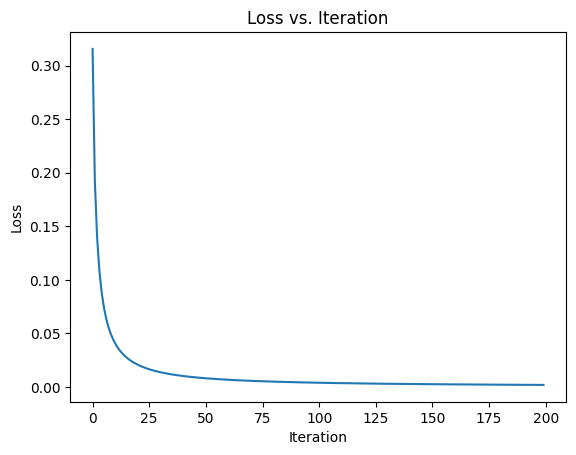

In [15]:
plot_losses(losses)

### Build same model with pyTorch 

In [161]:
import torch
import torch.nn as nn

class MLP_torch(nn.Module):
    def __init__(self):
        super(MLP_torch, self).__init__()
        self.fc1 = nn.Linear(3, 4)
        self.fc2 = nn.Linear(4, 4)
        # self.fc3 = nn.Linear(4, 4)
        self.fc4 = nn.Linear(4, 1)        

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        # x = torch.tanh(self.fc3(x))        
        x = self.fc4(x)  
        return x



model = MLP_torch()

# inputs
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5]
]

# desired targets
ys = [1.0, -1.0]

# convert to tensor
t_xs = torch.tensor(xs)

# add a dimension to the index=1 position to target tensor,
#  e.g. change size from [2] to [2, 1]
t_ys = torch.unsqueeze(torch.tensor(ys), 1)

# learning rate (i.e. step size)
learning_rate = 0.05

losses = []
for epoch in range(40):
    # forward pass
    outputs = model(t_xs)

    # calculate loss
    loss = torch.nn.functional.mse_loss(outputs, t_ys)

    # remove loss gradient 
    losses.append(loss.detach())

    # backpropagate
    loss.backward()

    # update weights
    for p in model.parameters():
        p.data -= learning_rate * p.grad.data

    # zero gradients
    for p in model.parameters():
        p.grad.data.zero_()

    if epoch % 10 == 0:
        print(f"Epoch {epoch} loss: {loss}")

prediction = model(t_xs)
print('')
print(f"Prediction:\n{prediction.detach()}")
print(f"Loss: {loss}")


Epoch 0 loss: 1.7117071151733398
Epoch 10 loss: 0.8498051166534424
Epoch 20 loss: 0.2081148624420166
Epoch 30 loss: 0.011945633217692375

Prediction:
tensor([[ 0.9857],
        [-0.9731]])
Loss: 0.0006465670885518193


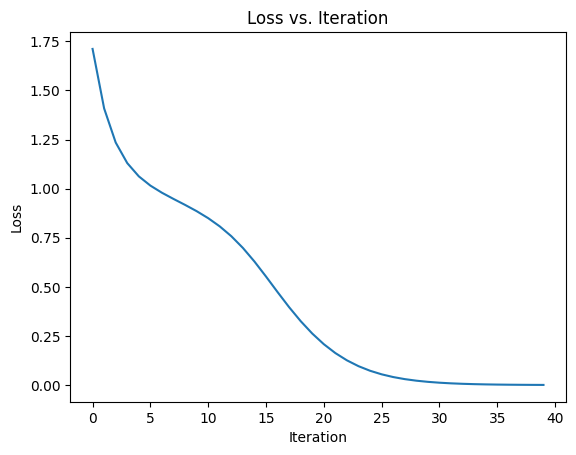

In [162]:
plot_losses(losses)

In [163]:
print(f'input xs:\n{xs}\n')
print(f'target ys:\n{ys}')
print('---------\n')
l_items = list(model.parameters())
if len(l_items) % 2 == 0:
  for i in range(0, len(l_items), 2):
    if i == 0:
      x0 = torch.clone(t_xs).detach() 
      input = torch.transpose(x0, 0, 1)
    else:
      input = output

    w = l_items[i].detach()  # remove gradient
    b_ = l_items[i + 1].detach()  # remove gradient
    b = torch.clone(b_).detach()  # remove gradient
    bT = torch.unsqueeze(b, 1)  # add a dimension to index 1 position
    w_input = torch.matmul(w, input)
    w_input_bT = torch.add(w_input, bT)

    if i == len(l_items) - 2:  # skip tanh activation on output node
      output = w_input_bT
    else:  
      output = torch.tanh(w_input_bT)      

    print(f'layer: {i / 2},  i: {i}\n')
    print(f'w,  {w.shape}:\n{w}\n')
    print(f'input,  {input.shape}:\n{input}\n')
    print(f'w * input,  {w_input.shape}:\n{w_input}\n')        
    print(f'bT,  {bT.shape}:\n{bT}\n')
    print(f'w * input + bT,  {w_input_bT.shape}:\n{w_input_bT}\n')
    print(f'output,  {output.shape}:\n{output}\n')            
    print('')
else:
  raise ValueError(f"len(l_items) {len(l_items)} is not divisible by 2.")

input xs:
[[2.0, 3.0, -1.0], [3.0, -1.0, 0.5]]

target ys:
[1.0, -1.0]
---------

layer: 0.0,  i: 0

w,  torch.Size([4, 3]):
tensor([[ 0.0323,  0.5735, -0.4385],
        [ 0.3694,  0.1024,  0.0826],
        [ 0.3109, -0.5274,  0.4482],
        [ 0.4119,  0.4129,  0.3148]])

input,  torch.Size([3, 2]):
tensor([[ 2.0000,  3.0000],
        [ 3.0000, -1.0000],
        [-1.0000,  0.5000]])

w * input,  torch.Size([4, 2]):
tensor([[ 2.2238, -0.6958],
        [ 0.9633,  1.0470],
        [-1.4085,  1.6843],
        [ 1.7476,  0.9802]])

bT,  torch.Size([4, 1]):
tensor([[-0.3189],
        [ 0.0361],
        [ 0.2407],
        [-0.1140]])

w * input + bT,  torch.Size([4, 2]):
tensor([[ 1.9049, -1.0147],
        [ 0.9994,  1.0832],
        [-1.1678,  1.9250],
        [ 1.6337,  0.8662]])

output,  torch.Size([4, 2]):
tensor([[ 0.9567, -0.7677],
        [ 0.7613,  0.7944],
        [-0.8236,  0.9583],
        [ 0.9266,  0.6994]])


layer: 1.0,  i: 2

w,  torch.Size([4, 4]):
tensor([[ 0.5313,  0.053

In [164]:
t_ys = torch.tensor(ys)
t_ys_ = torch.unsqueeze(t_ys, 0)
t_ys_.shape

torch.Size([1, 2])

In [165]:
t_ys = torch.tensor(ys)
t_ys_ = torch.unsqueeze(t_ys, 0)
t_ys_.shape

print(output, output.shape)
print(t_ys_, t_ys_.shape)

difference = output - t_ys_
squared_difference = torch.pow(difference, 2)
# loss = torch.sum(squared_difference) / len(squared_difference)

# loss = torch.sum(squared_difference)
loss = torch.mean(squared_difference)
loss

tensor([[ 0.9857, -0.9731]]) torch.Size([1, 2])
tensor([[ 1., -1.]]) torch.Size([1, 2])


tensor(0.0005)

In [192]:
print(output, output.shape)
print(torch.tensor(ys), torch.tensor(ys).shape)

difference = output - torch.tensor(ys)
print(f'difference: {difference}')
squared_difference = torch.pow(difference, 2)
print(f'squared_difference: {squared_difference}')
# loss = torch.sum(squared_difference) / len(squared_difference)
loss = torch.mean(squared_difference)
loss

tensor([[ 0.9993, -0.9989]]) torch.Size([1, 2])
tensor([ 1., -1.]) torch.Size([2])
difference: tensor([[-0.0007,  0.0011]])
squared_difference: tensor([[5.2957e-07, 1.1297e-06]])


tensor(8.2963e-07)

In [167]:
# for item in output.item:
#   print(item)
# type(output)
output.tolist()[0]


[0.9856690168380737, -0.9730886816978455]

In [168]:
import numpy as np

def mse_loss(y_true, y_pred):
  """Calculates the mean squared error loss.

  Args:
    y_true: The ground truth labels.
    y_pred: The predicted labels.

  Returns:
    The mean squared error loss.
  """

  loss = np.mean((y_true - y_pred)**2)
  return loss

def main():
  """Main function."""

  # y_true = np.array([1, 2, 3, 4, 5])
  y_true = np.array([1.0, -1.0])

  # y_pred = np.array([0, 1, 2, 3, 4])
  # y_pred = np.array([0.9997345209121704, -0.9980572462081909])
  y_pred = np.array(output.tolist()[0])  

  loss = mse_loss(y_true, y_pred)
  print(loss)

if __name__ == "__main__":
  main()

0.0004647980655736461


In [169]:
len(squared_difference)


1

In [170]:
t_ys = torch.tensor(ys)
t_ys_ = torch.unsqueeze(t_ys, 0)
t_ys_.shape

torch.nn.functional.mse_loss(output, t_ys_)

tensor(0.0005)

In [171]:
torch.sum((output - torch.tensor(ys))**2)


tensor(0.0009)

##### Check Output and Gradient Calculation with PyTorch

In [172]:
x0 = torch.Tensor([-3.0]).double();      x0.requires_grad = True
x1 = torch.Tensor([0.0]).double();       x1.requires_grad = True
x2 = torch.Tensor([0.5]).double();       x2.requires_grad = True
w0 = torch.Tensor([2.0]).double();       w0.requires_grad = True
w1 = torch.Tensor([1.0]).double();       w1.requires_grad = True
w2 = torch.Tensor([1.0]).double();       w2.requires_grad = True
b = torch.Tensor([4.61862664]).double(); b.requires_grad  = True
n = x0*w0 + x1*w1 + x2*w2 + b
o3 = torch.tanh(n)
o3.backward()

print('---- torch results matched backward pass results ----')
print(f'x0.data.item()  = {x0.data.item():>9.6f}')
print(f'x0.grad.item()  = {x0.grad.item():>9.6f}')
print(f'w0.data.item()  = {w0.data.item():>9.6f}')
print(f'w0.grad.item()  = {w0.grad.item():>9.6f} <-- result matched micrograd')
print('---')
print(f'x1.data.item()  = {x1.data.item():>9.6f}')
print(f'x1.grad.item()  = {x1.grad.item():>9.6f}')
print(f'w1.data.item()  = {w1.data.item():>9.6f}')
print(f'w1.grad.item()  = {w1.grad.item():>9.6f}')
print('---')
print(f'x2.data.item()  = {x2.data.item():>9.6f}')
print(f'x2.grad.item()  = {x2.grad.item():>9.6f}')
print(f'w2.data.item()  = {w2.data.item():>9.6f}')
print(f'w2.grad.item()  = {w2.grad.item():>9.6f}')
print('---')
print(f'out.data.item() = {o3.data.item():>9.6f} <-- result matched micrograd')


---- torch results matched backward pass results ----
x0.data.item()  = -3.000000
x0.grad.item()  =  1.000000
w0.data.item()  =  2.000000
w0.grad.item()  = -1.500000 <-- result matched micrograd
---
x1.data.item()  =  0.000000
x1.grad.item()  =  0.500000
w1.data.item()  =  1.000000
w1.grad.item()  =  0.000000
---
x2.data.item()  =  0.500000
x2.grad.item()  =  0.500000
w2.data.item()  =  1.000000
w2.grad.item()  =  0.250000
---
out.data.item() = -0.707107 <-- result matched micrograd


### Neural Network MLP(3, [4, 4, 1])
    input layer:     3 nodes
    hidden layer 1:  4 nodes
    hidden layer 2:  4 nodes
    output layer:    1 node

<!-- ![Getting Started](..\karpathy\img\Nertual_Network_Neuron.PNG) -->
<img src="..\karpathy\img\neural_network_neuron.PNG">

### Create neural work, initialize weights and biases, define inputs and desired outputs 

In [173]:
# create neural network and initialize weights and biases
n = MLP(3, [4, 4, 1])

# inputs
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5]
]

# desired targets
ys = [1.0, -1.0]

# learning rate (i.e. step size)
learning_rate = 0.05

In [174]:
# number of parameters (e.g sum (weights + bias to each neuron and output))
# MLP(3, [4, 4, 1]) --> 4_neurons(3_inputs + 1_bias) + 4_neurons(4_neurons + 1_bias) + 1_output(4_neurons + 1_bias) = 41_parameters 
print(f'parameters in MLP: {len(n.parameters())}\n')

# print first 5 parameters
for i, v in enumerate(n.parameters()):
  if i < 5:
    print(f'i: {i:>2}, {v.data:>14.10f}')
 
print('---')

# print last 5 parameters   
for i, v in enumerate(n.parameters()):
  if i >= len(n.parameters()) - 5:
    print(f'i: {i:>2}, {v.data:>14.10f}')

parameters in MLP: 41

i:  0,  -0.0595583587
i:  1,   0.0479337552
i:  2,  -0.5171004357
i:  3,  -0.9632198723
i:  4,   0.3617205167
---
i: 36,  -0.1352628129
i: 37,   0.4807745370
i: 38,  -0.0210609339
i: 39,  -0.6264901106
i: 40,   0.5305867788


### ---- Start: Calculate Neural Network Output and Loss with Matrix Multiplication ----

##### Transpose inputs xs

In [175]:
xs_mats = [np.array(xs)]  # convert xs to list of np.arrays
xs_mats_T = []
for mat in xs_mats:
  mat_transpose = np.transpose(mat)
  xs_mats_T.append(mat_transpose)

print(f'xs_mats[0].shape: {xs_mats[0].shape}')
print(f'xs_mats:\n{xs_mats}\n')
print(f'xs_mats_T[0].shape: {xs_mats_T[0].shape}')
print(f'xs_mats_T:\n{xs_mats_T}')

xs_mats[0].shape: (2, 3)
xs_mats:
[array([[ 2. ,  3. , -1. ],
       [ 3. , -1. ,  0.5]])]

xs_mats_T[0].shape: (3, 2)
xs_mats_T:
[array([[ 2. ,  3. ],
       [ 3. , -1. ],
       [-1. ,  0.5]])]


##### Get Neural Network's Weights and Biases Matrices

In [176]:
layer_cnt = len(n.layers)
w_mats = []  # list of weights matrix for each layer 
b_mats = []  # list of bias matrix for each layer
print(f'layer_cnt: {layer_cnt}\n')
for i, layer in enumerate(n.layers):
    neuron_cnt = len(layer.neurons)
    print(f'layer: {i}, neuron_cnt: {neuron_cnt}')

    print('----')
    b_mat = []  # accumulate neuon's bias for each row     
    for j, neuron in enumerate(layer.neurons):
        print(f'layer: {i}, neuron {j}')
        b = neuron.b.data  # bias of neuron 
        w_row = []  # accumulate neuon's weights for each row
        # b_row = []  # accumulate neuon's bias for each row
        for k, w in enumerate(neuron.w):
            w_row.append(w.data)
            print(f'w{k}: {w.data:10.7f},   w{k}.grad: {w.grad:10.7f}')
        if j == 0:            
            w_mat = np.array([w_row])
        else:
            w_mat = np.vstack((w_mat, w_row))
        
        b_mat.append(b)
        print(f'b:  {b:10.7f}\n')
        # print(f'b:  {b:10.7f}')        
        # print(f'b_mat:  {b_mat}\n')
    w_mats.append(w_mat)  
    b_mats.append(np.array([b_mat]))        
    print('------')

layer_cnt: 3

layer: 0, neuron_cnt: 4
----
layer: 0, neuron 0
w0: -0.0595584,   w0.grad:  0.0000000
w1:  0.0479338,   w1.grad:  0.0000000
w2: -0.5171004,   w2.grad:  0.0000000
b:  -0.9632199

layer: 0, neuron 1
w0:  0.3617205,   w0.grad:  0.0000000
w1: -0.1557562,   w1.grad:  0.0000000
w2:  0.6212911,   w2.grad:  0.0000000
b:  -0.7099469

layer: 0, neuron 2
w0:  0.8091953,   w0.grad:  0.0000000
w1:  0.8478112,   w1.grad:  0.0000000
w2:  0.1197954,   w2.grad:  0.0000000
b:  -0.1039363

layer: 0, neuron 3
w0:  0.2065243,   w0.grad:  0.0000000
w1:  0.4537167,   w1.grad:  0.0000000
w2: -0.8501041,   w2.grad:  0.0000000
b:   0.7787010

------
layer: 1, neuron_cnt: 4
----
layer: 1, neuron 0
w0:  0.3733739,   w0.grad:  0.0000000
w1: -0.0950549,   w1.grad:  0.0000000
w2:  0.9266131,   w2.grad:  0.0000000
w3:  0.2690674,   w3.grad:  0.0000000
b:  -0.1632371

layer: 1, neuron 1
w0: -0.3290612,   w0.grad:  0.0000000
w1:  0.8096186,   w1.grad:  0.0000000
w2: -0.5836620,   w2.grad:  0.0000000
w3: -

##### Print Neural Network's Weights and Biases Matrices

In [177]:
zipped_w_n_b = zip(w_mats, b_mats)
for i, w_n_b in enumerate(zipped_w_n_b):
  print(f'i: {i}')    
  print(f'w_mat{w_n_b[0].shape}:\n{w_n_b[0]}')
  print(f'b_mat{w_n_b[1].shape}:\n{w_n_b[1]}\n')  
    

i: 0
w_mat(4, 3):
[[-0.05955836  0.04793376 -0.51710044]
 [ 0.36172052 -0.1557562   0.6212911 ]
 [ 0.80919532  0.84781121  0.11979539]
 [ 0.20652425  0.45371666 -0.85010415]]
b_mat(1, 4):
[[-0.96321987 -0.70994686 -0.10393633  0.77870102]]

i: 1
w_mat(4, 4):
[[ 0.37337389 -0.0950549   0.92661309  0.26906739]
 [-0.32906122  0.80961855 -0.58366203 -0.87494825]
 [ 0.09212576 -0.33715978 -0.38950542 -0.12763305]
 [-0.35576052  0.7711136   0.00508118  0.87634639]]
b_mat(1, 4):
[[-0.16323709  0.69828338  0.48220923 -0.61315159]]

i: 2
w_mat(1, 4):
[[-0.13526281  0.48077454 -0.02106093 -0.62649011]]
b_mat(1, 1):
[[0.53058678]]



##### Calculate Neural Network Output and Loss with Matrix Multiplication

<img src="..\karpathy\img\neural_mat.PNG">

In [178]:
verbose = True   # print calculation output and weights and bias matrices 
# verbose = False  # print calculation output only

for layer in range(len(n.layers)):
  if layer == 0:  # first layer, use given inputs xs as inputs
    input = xs_mats_T[layer]
  else:  # after first layer, use outputs from preceding layers as inputs
    input = output

  weights = w_mats[layer]
  bias = np.transpose(b_mats[layer])

  weights_x_input = np.matmul(weights, input)
  weights_x_input_plus_bias = weights_x_input + bias

  # output = np.tanh(np.matmul(weights, input) + bias)
  output = np.tanh(weights_x_input_plus_bias)

  if verbose:
    print(f'{"-"*50}')
    print(f'layer: {layer}')
    print(f'weights {weights.shape}:\n{weights}\n')
    print(f'input {input.shape}:\n{input}\n')

    print(f'weights_x_inputs {weights_x_input.shape}:\n{weights_x_input}\n')
    print(f'bias {bias.shape}:\n{bias}\n')
    print(f'weights_x_inputs_plus_bias {weights_x_input_plus_bias.shape}:\n{weights_x_input_plus_bias}\n')

    print(f'output {output.shape}:\n{output}\n')    

yout = output[0]
loss = sum((yout - ys)**2)

print(f'-- manual forward pass calculation --')
print(f'manual calculation: {yout}')   
print(f'desired output:     {ys}')   
print(f'loss:               {loss}')


--------------------------------------------------
layer: 0
weights (4, 3):
[[-0.05955836  0.04793376 -0.51710044]
 [ 0.36172052 -0.1557562   0.6212911 ]
 [ 0.80919532  0.84781121  0.11979539]
 [ 0.20652425  0.45371666 -0.85010415]]

input (3, 2):
[[ 2.   3. ]
 [ 3.  -1. ]
 [-1.   0.5]]

weights_x_inputs (4, 2):
[[ 0.54178498 -0.48515905]
 [-0.36511866  1.5515633 ]
 [ 4.04202889  1.63967244]
 [ 2.62430263 -0.25919597]]

bias (4, 1):
[[-0.96321987]
 [-0.70994686]
 [-0.10393633]
 [ 0.77870102]]

weights_x_inputs_plus_bias (4, 2):
[[-0.42143489 -1.44837892]
 [-1.07506552  0.84161643]
 [ 3.93809256  1.53573611]
 [ 3.40300366  0.51950505]]

output (4, 2):
[[-0.39813856 -0.89537187]
 [-0.79136204  0.68666428]
 [ 0.99924093  0.91140109]
 [ 0.99778824  0.47731792]]

--------------------------------------------------
layer: 1
weights (4, 4):
[[ 0.37337389 -0.0950549   0.92661309  0.26906739]
 [-0.32906122  0.80961855 -0.58366203 -0.87494825]
 [ 0.09212576 -0.33715978 -0.38950542 -0.12763305]
 [

### ### ---- End: Calculate Neural Network Output and Loss with Matrix Multiplication ---- ----

### Prediction with Micrograd Neural Network

##### Micrograd Forward Pass Results, Same as Matrix Multiplication

In [179]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))  # low loss is better, perfect is loss = 0
ypred_data = [v.data for v in ypred] 
loss_data = loss.data

print(f'-- micrograd forward pass calculation --')
print(f'ypred_data:         {ypred_data}')
print(f'ys:                 {ys}')
print(f'loss_data:          {loss_data}')

-- micrograd forward pass calculation --
ypred_data:         [0.1398915676253791, 0.3624166971674228]
ys:                 [1.0, -1.0]
loss_data:          2.5959657721625167


#### Micrograd backward pass and update parameters

In [180]:
# backward pass to calculate gradients
for p in n.parameters():
  p.grad = 0.0  # zero the gradient 
loss.backward()

# update weights and bias
if verbose:
  print('=== update parameters ===')
  print(f'  i  parameter before         gradient     learning rate      parameter after')
for i, p in enumerate(n.parameters()):
  p_before = p.data
  p.data += -learning_rate * p.grad
  if verbose:    
    print(f'{i:>3}  {p_before:>16.10f}   {p.grad:>14.10f}    {learning_rate:>14.5f}       {p.data:>14.10f}')

=== update parameters ===
  i  parameter before         gradient     learning rate      parameter after
  0     -0.0595583587    -0.4279813948           0.05000        -0.0381592890
  1      0.0479337552    -0.6196041784           0.05000         0.0789139641
  2     -0.5171004357     0.2058569106           0.05000        -0.5273932812
  3     -0.9632198723    -0.2119572507           0.05000        -0.9526220098
  4      0.3617205167     0.3320974174           0.05000         0.3451156459
  5     -0.1557561986     0.6874861087           0.05000        -0.1901305040
  6      0.6212910959    -0.2348996115           0.05000         0.6330360765
  7     -0.7099468621     0.1832614344           0.05000        -0.7191099338
  8      0.8091953202    -0.3608768081           0.05000         0.8272391606
  9      0.8478112127     0.1214899154           0.05000         0.8417367169
 10      0.1197953892    -0.0605816423           0.05000         0.1228244713
 11     -0.1039363307    -0.1201833925

### Improve Prediction with Parameter Iteration 

In [181]:
# Create a list of losses
losses = []
for k in range(200):
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))  # low loss is better, perfect is loss = 0
  losses.append(loss.data)

  # backward pass to calculate gradients
  for p in n.parameters():
    p.grad = 0.0  # zero the gradient 
  loss.backward()

  # update weights and bias
  for p in n.parameters():
      p.data += -learning_rate * p.grad

  # print(f'x: {x}')
  print(f'ypred: {ypred}')
  print(f'step: {k}, loss: {loss.data}')   
  print('-------')  

ypred: [Value(data = 0.3484949404476199), Value(data = -0.06414098258326337)]
step: 0, loss: 1.3002909431025702
-------
ypred: [Value(data = 0.47591100267528946), Value(data = -0.25044545608999774)]
step: 1, loss: 0.8365012914129517
-------
ypred: [Value(data = 0.5536886388317345), Value(data = -0.3766863694698142)]
step: 2, loss: 0.587713713112591
-------
ypred: [Value(data = 0.6092386286644018), Value(data = -0.4658751640251882)]
step: 3, loss: 0.4379837897331969
-------
ypred: [Value(data = 0.6508921687464994), Value(data = -0.5310307229077517)]
step: 4, loss: 0.34180846069894866
-------
ypred: [Value(data = 0.6830544743852438), Value(data = -0.5802415553464975)]
step: 5, loss: 0.2766516180651416
-------
ypred: [Value(data = 0.7085733657775131), Value(data = -0.6185746023336756)]
step: 6, loss: 0.23041481711916093
-------
ypred: [Value(data = 0.7293237342911756), Value(data = -0.6492517019913071)]
step: 7, loss: 0.19629000937406896
-------
ypred: [Value(data = 0.7465571430463738), V

ypred: [Value(data = 0.8864082011578738), Value(data = -0.8643172791368611)]
step: 36, loss: 0.03131289750501454
-------
ypred: [Value(data = 0.888115358526941), Value(data = -0.8664705312654679)]
step: 37, loss: 0.030348292018081334
-------
ypred: [Value(data = 0.8897531675337693), Value(data = -0.8685325337570236)]
step: 38, loss: 0.029438058749185286
-------
ypred: [Value(data = 0.8913261136410932), Value(data = -0.8705093965914892)]
step: 39, loss: 0.028577829947448834
-------
ypred: [Value(data = 0.8928382897601619), Value(data = -0.8724066791826914)]
step: 40, loss: 0.027763687658715654
-------
ypred: [Value(data = 0.8942934391291157), Value(data = -0.874229452044284)]
step: 41, loss: 0.026992107744231008
-------
ypred: [Value(data = 0.8956949926215435), Value(data = -0.8759823502686772)]
step: 42, loss: 0.02625991200910093
-------
ypred: [Value(data = 0.8970461013184136), Value(data = -0.8776696200673255)]
step: 43, loss: 0.025564227108210852
-------
ypred: [Value(data = 0.89834

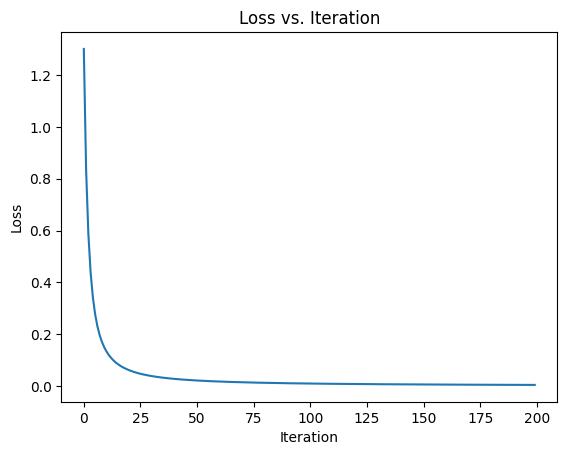

In [182]:
plot_losses(losses)

### Build same model with pyTorch 

In [183]:
import torch
import torch.nn as nn

class MLP_torch(nn.Module):
    def __init__(self):
        super(MLP_torch, self).__init__()
        self.fc1 = nn.Linear(3, 4)
        self.fc2 = nn.Linear(4, 4)
        # self.fc3 = nn.Linear(4, 4)
        self.fc4 = nn.Linear(4, 1)        

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        # x = torch.tanh(self.fc3(x))        
        x = self.fc4(x)  
        return x



model = MLP_torch()

# inputs
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5]
]

# desired targets
ys = [1.0, -1.0]

# convert to tensor
t_xs = torch.tensor(xs)

# add a dimension to the index=1 position to target tensor,
#  e.g. change size from [2] to [2, 1]
t_ys = torch.unsqueeze(torch.tensor(ys), 1)

# learning rate (i.e. step size)
learning_rate = 0.05

losses = []
for epoch in range(40):
    # forward pass
    outputs = model(t_xs)

    # calculate loss
    loss = torch.nn.functional.mse_loss(outputs, t_ys)

    # remove loss gradient 
    losses.append(loss.detach())

    # backpropagate
    loss.backward()

    # update weights
    for p in model.parameters():
        p.data -= learning_rate * p.grad.data

    # zero gradients
    for p in model.parameters():
        p.grad.data.zero_()

    if epoch % 10 == 0:
        print(f"Epoch {epoch} loss: {loss}")

prediction = model(t_xs)
print('')
print(f"Prediction:\n{prediction.detach()}")
print(f"Loss: {loss}")


Epoch 0 loss: 1.164993405342102
Epoch 10 loss: 0.19609788060188293
Epoch 20 loss: 0.005849550478160381
Epoch 30 loss: 7.394792919512838e-05

Prediction:
tensor([[ 0.9993],
        [-0.9989]])
Loss: 1.3012120234634494e-06


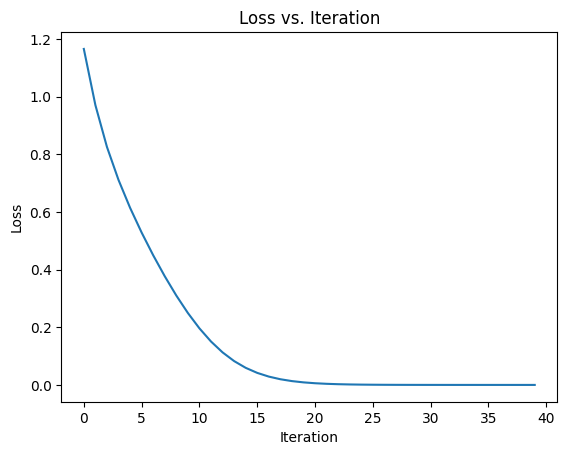

In [184]:
plot_losses(losses)

In [185]:
print(f'input xs:\n{xs}\n')
print(f'target ys:\n{ys}')
print('---------\n')
l_items = list(model.parameters())
if len(l_items) % 2 == 0:
  for i in range(0, len(l_items), 2):
    if i == 0:
      x0 = torch.clone(t_xs).detach() 
      input = torch.transpose(x0, 0, 1)
    else:
      input = output

    w = l_items[i].detach()  # remove gradient
    b_ = l_items[i + 1].detach()  # remove gradient
    b = torch.clone(b_).detach()  # remove gradient
    bT = torch.unsqueeze(b, 1)  # add a dimension to index 1 position
    w_input = torch.matmul(w, input)
    w_input_bT = torch.add(w_input, bT)

    if i == len(l_items) - 2:  # skip tanh activation on output node
      output = w_input_bT
    else:  
      output = torch.tanh(w_input_bT)      

    print(f'layer: {i / 2},  i: {i}\n')
    print(f'w,  {w.shape}:\n{w}\n')
    print(f'input,  {input.shape}:\n{input}\n')
    print(f'w * input,  {w_input.shape}:\n{w_input}\n')        
    print(f'bT,  {bT.shape}:\n{bT}\n')
    print(f'w * input + bT,  {w_input_bT.shape}:\n{w_input_bT}\n')
    print(f'output,  {output.shape}:\n{output}\n')            
    print('')
else:
  raise ValueError(f"len(l_items) {len(l_items)} is not divisible by 2.")

input xs:
[[2.0, 3.0, -1.0], [3.0, -1.0, 0.5]]

target ys:
[1.0, -1.0]
---------

layer: 0.0,  i: 0

w,  torch.Size([4, 3]):
tensor([[ 0.1047, -0.3425,  0.0168],
        [-0.4104,  0.5775, -0.3041],
        [ 0.0247, -0.5172, -0.5745],
        [ 0.5708, -0.1385, -0.0259]])

input,  torch.Size([3, 2]):
tensor([[ 2.0000,  3.0000],
        [ 3.0000, -1.0000],
        [-1.0000,  0.5000]])

w * input,  torch.Size([4, 2]):
tensor([[-0.8348,  0.6650],
        [ 1.2159, -1.9606],
        [-0.9276,  0.3041],
        [ 0.7518,  1.8380]])

bT,  torch.Size([4, 1]):
tensor([[-0.1152],
        [ 0.4799],
        [-0.1531],
        [ 0.2568]])

w * input + bT,  torch.Size([4, 2]):
tensor([[-0.9500,  0.5498],
        [ 1.6958, -1.4807],
        [-1.0807,  0.1510],
        [ 1.0086,  2.0948]])

output,  torch.Size([4, 2]):
tensor([[-0.7398,  0.5004],
        [ 0.9349, -0.9016],
        [-0.7935,  0.1498],
        [ 0.7652,  0.9701]])


layer: 1.0,  i: 2

w,  torch.Size([4, 4]):
tensor([[-0.2302, -0.628

In [186]:
t_ys = torch.tensor(ys)
t_ys_ = torch.unsqueeze(t_ys, 0)
t_ys_.shape

torch.Size([1, 2])

In [187]:
t_ys = torch.tensor(ys)
t_ys_ = torch.unsqueeze(t_ys, 0)
t_ys_.shape

print(output, output.shape)
print(t_ys_, t_ys_.shape)

difference = output - t_ys_
squared_difference = torch.pow(difference, 2)
# loss = torch.sum(squared_difference) / len(squared_difference)
loss = torch.sum(squared_difference)
loss

tensor([[ 0.9993, -0.9989]]) torch.Size([1, 2])
tensor([[ 1., -1.]]) torch.Size([1, 2])


tensor(1.6593e-06)

In [188]:
print(output, output.shape)
print(torch.tensor(ys), torch.tensor(ys).shape)

difference = output - torch.tensor(ys)
print(f'difference: {difference}')
squared_difference = torch.pow(difference, 2)
print(f'squared_difference: {squared_difference}')
# loss = torch.sum(squared_difference) / len(squared_difference)
loss = torch.sum(squared_difference) / 2
loss

tensor([[ 0.9993, -0.9989]]) torch.Size([1, 2])
tensor([ 1., -1.]) torch.Size([2])
difference: tensor([[-0.0007,  0.0011]])
squared_difference: tensor([[5.2957e-07, 1.1297e-06]])


tensor(8.2963e-07)

In [189]:
difference
len(squared_difference)

1

In [190]:
t_ys = torch.tensor(ys)
t_ys_ = torch.unsqueeze(t_ys, 0)
t_ys_.shape

torch.nn.functional.mse_loss(output, t_ys_)

tensor(8.2963e-07)

In [191]:
torch.sum((output - torch.tensor(ys))**2)

tensor(1.6593e-06)